In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import sys, os
sys.path.append('../')
from data_handling import Container,load_data,Normalize,Denormalize
from plot_style.style_prab import load_preset,figsize,cmap_nicify
from plot_style.style_prab import colors as colors_preset
from train_ensemble import train, NN, Loss
from analysis.scan_model import median,quantile
load_preset(scale=1,font_path='../plot_style/font')
import pickle
mymap = cmap_nicify(cmap='YlGnBu_r',idx_white=1,size_white=50)
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches


matplotlib preset loaded


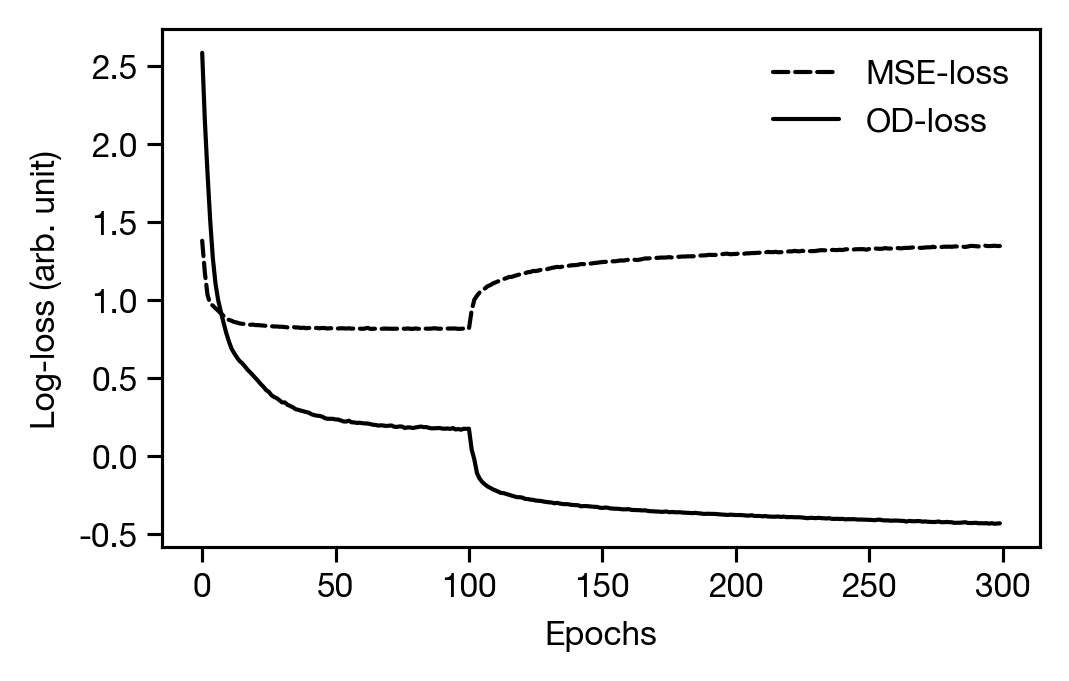

In [2]:
import re

fp = './models/ensamble_net.log-2024_03_05_14_55.log'
loss = []
OD_loss = []
with open(fp) as file:
    for line in file:
        l = re.search(r'(?<=MSE-Loss: )\d+.\d+', line)
        l1 = re.search(r'(?<=OD-Loss: )\d+.\d+', line)
        if l:
            loss.append(float(l.group(0)))
        if l1:
            OD_loss.append(float(l1.group(0)))
plt.plot(np.log(loss),'k--', label='MSE-loss')
plt.plot(np.log(OD_loss),'k', label='OD-loss')
plt.xlabel('Epochs')
plt.ylabel('Log-loss (arb. unit)')
plt.legend(frameon=False)
plt.savefig('figures/loss_plot.png')

In [3]:
import pickle
from ensemble.Bregressor_ import BaggingRegressor
from ensemble.utils import io

model_path = '../models/'
with open(f'{model_path}config.pkl', 'rb') as fp:
    config = pickle.load(fp)
    norm = config['norm']


if isinstance(config['model'],list):
    model = nn.ModuleList(config['model'])

    ensemble = BaggingRegressor(estimator=model,               # estimator is your pytorch model
                                n_estimators=config['estimators'],
                                cuda=False,)
    ensemble.set_criterion(config['loss_fun'])
    io.load(ensemble, model_path)
else:
    model = config['model']
    ensemble = BaggingRegressor_te(estimator=model,               # estimator is your pytorch model
                                n_estimators=config['estimators'],
                                cuda=False,)
    ensemble.set_criterion(config['loss_fun'])
    io_te.load(ensemble, model_path)
    
    
path='../data/dataframe_combined_espec_interpolated_gaia_energy_2022.h5'
trainset, testset, _ = load_data(
config["path"],
config["inputs"],
config["outputs"],
samples=config['samples'],
ratio=config['ratio'],
start_ind=0,
norm=norm,
random=False,
)

trainset = Container(trainset)
testset = Container(testset)

testset.x = testset.x.to('cpu')
testset.y = testset.y.to('cpu')


In [4]:
x_ = torch.linspace(-2.5,2.5,100)
y_ = torch.linspace(-2.5,2.5,100)
grid_x, grid_y = torch.meshgrid(x_, y_, indexing='ij')
x = torch.zeros(100**2,14)
x[:,0] = grid_y.flatten()
x[:,8] = grid_x.flatten()

y_pred = median(x,ensemble).detach().numpy()
y_pred_q_low,y_pred_q_high = quantile(x,ensemble)
y_pred = Denormalize(y_pred,norm[1])
y_pred_q_low = Denormalize(y_pred_q_low,norm[1])
y_pred_q_high = Denormalize(y_pred_q_high,norm[1])

y_pred = y_pred.reshape(100,100,5)
y_pred_q_low = y_pred_q_low.reshape(100,100,5)
y_pred_q_high = y_pred_q_high.reshape(100,100,5)

x = Denormalize(x,norm[0])
x = x.reshape(100,100,14)


In [5]:

# conversion factors
c_zfoc = ((162*1e3)/6.9)
c_le = np.array([37.3944085944582, -0.8896545892497185])*0.6


model_data = {}
model_data['x'] = (x[:,50,8].detach().numpy()-norm[0][0][8])*c_zfoc
model_data['y'] = x[50,:,0].detach().numpy()*c_le[0] + c_le[1]

model_data['med'] = y_pred[:,:,0]
model_data['mad'] = y_pred[:,:,1]
model_data['q'] = y_pred[:,:,2]
model_data['med_q_low'] = y_pred_q_low[:,:,0]
model_data['mad_q_low'] = y_pred_q_low[:,:,1]
model_data['q_q_low'] = y_pred_q_low[:,:,2]
model_data['med_q_high'] = y_pred_q_high[:,:,0]
model_data['mad_q_high'] = y_pred_q_high[:,:,1]
model_data['q_q_high'] = y_pred_q_high[:,:,2]


In [6]:
with open('../data/sobol_data.pkl', 'rb') as handle:
    d = pickle.load(handle)
    
med = d['med']
mad = d['mad']
q = d['q']
points = d['points']
# energy from compin to target 60%
points[:,1] *= 0.6

In [10]:

min_ = np.min(points,axis=0)
max_ = np.max(points,axis=0)
sx =  0.005
sy =  0.004

# for interpolation
grid_x, grid_y = np.meshgrid(np.arange(min_[0],max_[0],sx), np.arange(min_[1],max_[1],sy))

# filter
f = ~np.isnan(mad)

cx = 4.687599999999975 + 0.1
cy = 4.2879000000000005*0.6


lx = (model_data['x'].max() - model_data['x'].min())/1000
ly = (model_data['y'].max() - model_data['y'].min())
cutx_min = np.argwhere(grid_x[0,:]>cx)[0][0]
cuty_min = np.argwhere(grid_y[:,0]>cy)[0][0]
cutx_max = np.argwhere(grid_x[0,:]>(cx+lx))[0][0]
cuty_max = np.argwhere(grid_y[:,0]>cy+ly)[0][0]


# for plotting 
gx = (grid_x - cx - lx/2) * 1000 
gy = grid_y

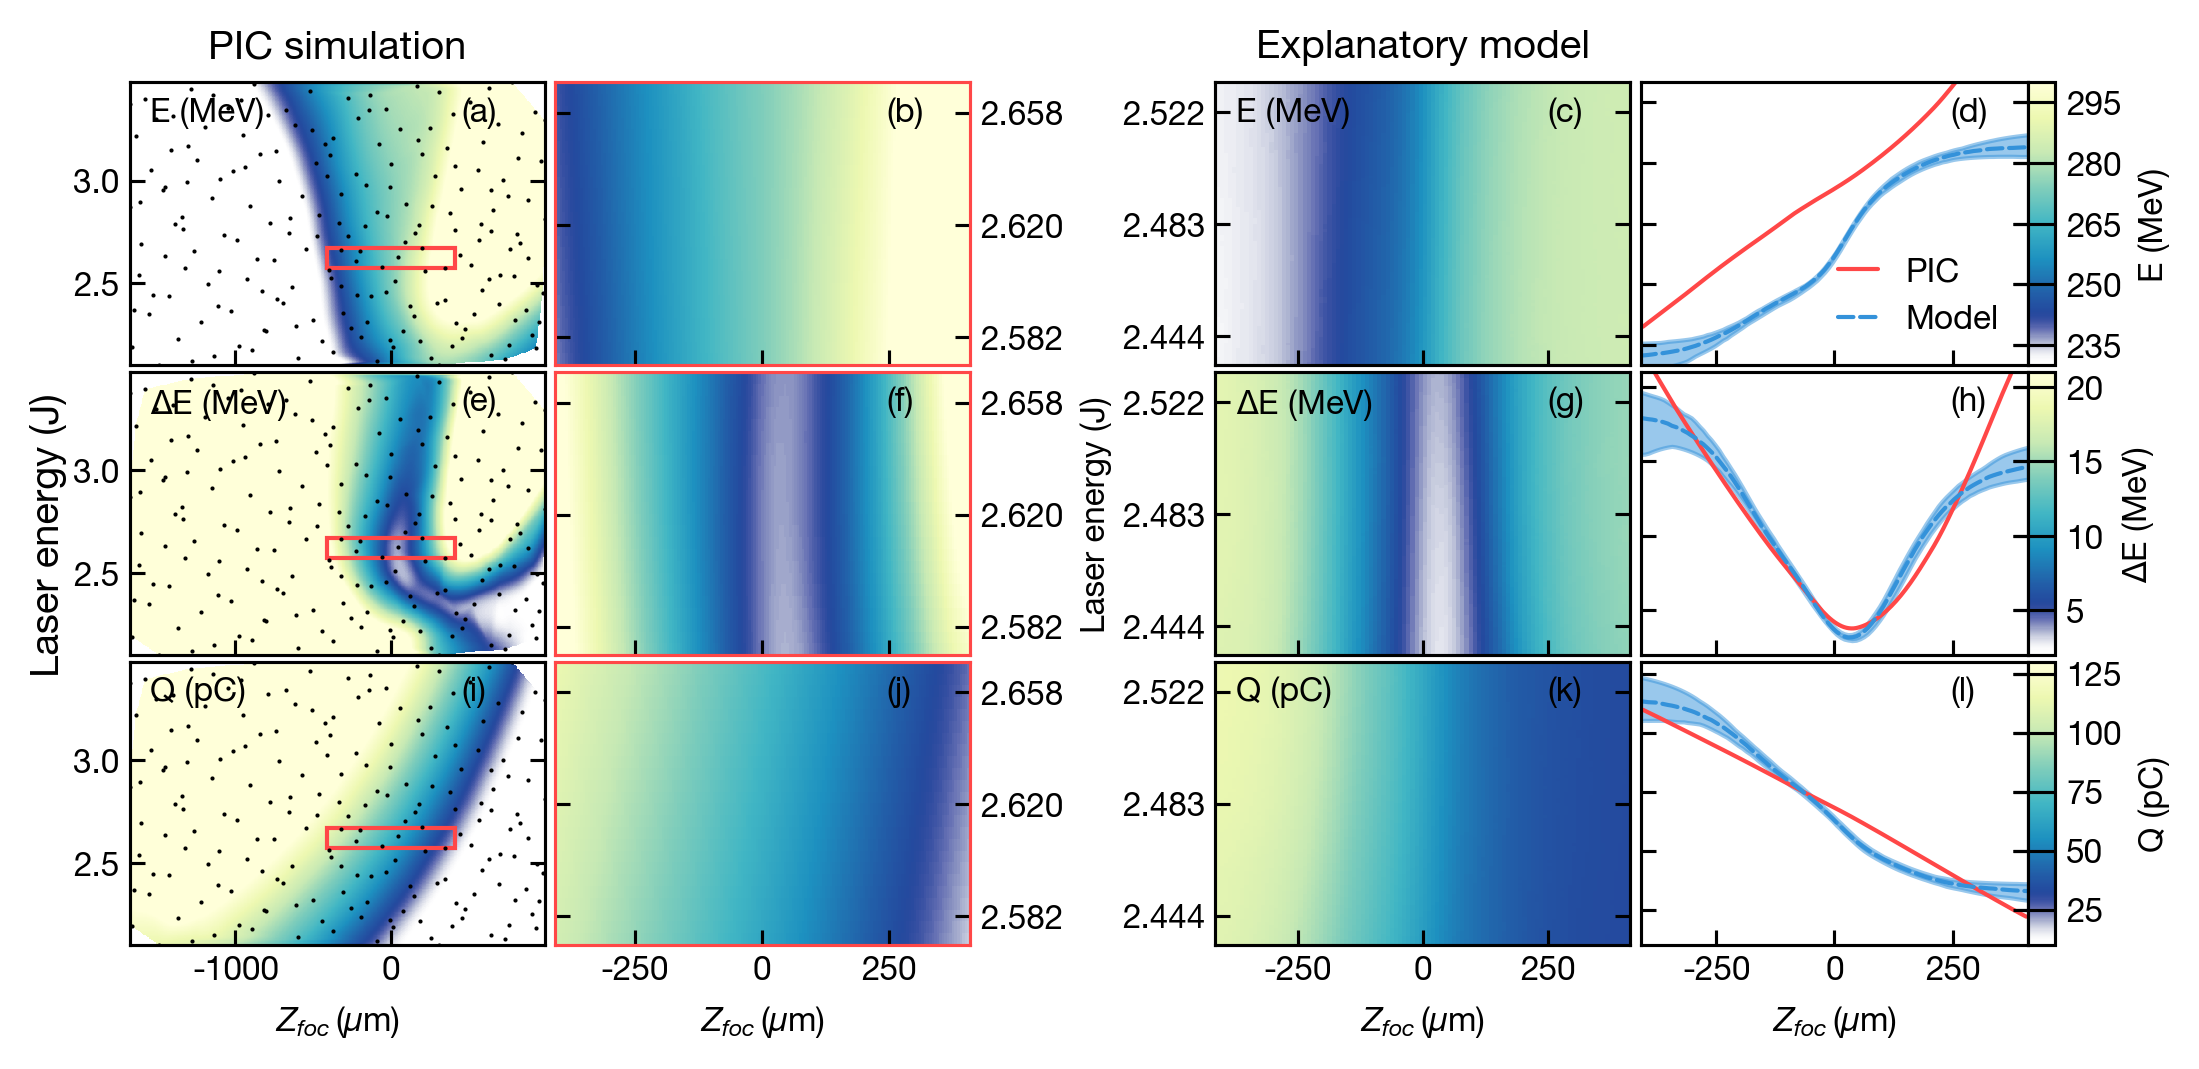

In [31]:



def plot(sim,d_str,axs,ticks,elim,label):

    grid_z = griddata(points[f], sim[f], (grid_x, grid_y), method='cubic')
    grid_z[np.isnan(grid_z)] = 0
    
    
    im = axs[0].pcolormesh(gx[0,:],gy[:,0],grid_z,cmap=mymap,vmin=elim[0],vmax=elim[1])
    axs[0].plot((points[:,0]-cx-lx/2)*1e3,points[:,1],'.',ms=2,color='k',mew=0)
    
    rect = patches.Rectangle((-1e3*lx/2, cy), lx*1e3, ly, linewidth=1, edgecolor=colors_preset[0], facecolor='none')
    axs[0].add_patch(rect)
    
    divider = make_axes_locatable(axs[3])
    cax = divider.append_axes('right', size='7%', pad=0.)
    cb = fig.colorbar(im, cax=cax, orientation='vertical')
    cb.ax.tick_params('y', direction='in',length=10)
    cb.set_ticks(ticks)
    cb.ax.set_ylabel(label)
    
    axs[2].pcolormesh(model_data['x'],model_data['y'],model_data[d_str].T,cmap=mymap,vmin=elim[0],vmax=elim[1])

    axs[1].pcolormesh(gx[0,cutx_min:cutx_max],gy[cuty_min:cuty_max,0],grid_z[cuty_min:cuty_max,cutx_min:cutx_max],cmap=mymap,vmin=elim[0],vmax=elim[1])

    sim_zfoc_x = gx[0,cutx_min:cutx_max]
    sim_zfoc_y = grid_z[cuty_min+(-cuty_min+cuty_max)//2,cutx_min:cutx_max]
    
    axs[3].plot(sim_zfoc_x,sim_zfoc_y,color=colors_preset[0],label='PIC')
    axs[3].plot(model_data['x'],model_data[d_str][:,50],'--',color=colors_preset[3],label='Model',)
    axs[3].fill_between(model_data['x'],
                        model_data[d_str+'_q_low'][:,50],
                        model_data[d_str+'_q_high'][:,50],
                        color=colors_preset[3],
                        alpha=0.5)

    
    return cb
    

def remove_all_ticks(axs):
    for a in axs.flatten():
        a.tick_params('x',
              bottom=True,      # ticks along the bottom edge are off
              labelbottom=False,
              top=False,      # ticks along the bottom edge are off
              labeltop=False,
              direction='in')
        a.tick_params('y',
              right=True,      # ticks along the bottom edge are off
              labelright=False,
              left=True,      # ticks along the bottom edge are off
              labelleft=False,
              direction='in')  
   
fig_w = figsize['inch']['column_width']
fig,axs = plt.subplots(3,4,figsize=(fig_w*2,fig_w),constrained_layout=True)


labels = [r'E (MeV)',r'$\Delta$E (MeV)','Q (pC)']
ticks = [[235,250,265,280,295],
         [5,10,15,20],
         [25,50,75,100,125]]
elim = [[230,300],
        [2,21],
        [10,130]]
yticks = [2.50,2.45]
xlim = (np.array([points[:,0].min(),points[:,0].max()])-cx-lx/2)*1e3
ylim = np.array([points[:,1].min(),points[:,1].max()]) #- cy - ly/2 + model_data['y'][50]


cb_med = plot(med,'med',axs[0,:],ticks[0],elim[0],labels[0])
cb_mad = plot(mad,'mad',axs[1,:],ticks[1],elim[1],labels[1])
cb_q = plot(q,'q',axs[2,:],ticks[2],elim[2],labels[2])

remove_all_ticks(axs)

for i in range(3): 
    axs[i,0].tick_params('y',labelleft=True,) 
    axs[i,1].tick_params('y',labelright=True,) 
    axs[i,2].tick_params('y',labelleft=True,) 
    #axs[i,2].set_ylim(gy[cuty_min,0],gy[cuty_max-1,0])
    #axs[i,1].sharey(axs[i,2])
    
    ylim2 = axs[i,2].get_ylim()
    axs[i,2].set_yticks(np.round(np.linspace(ylim2[0]+0.01,ylim2[1]-0.01,3),3))
    ylim1 = axs[i,1].get_ylim()
    axs[i,1].set_yticks(np.round(np.linspace(ylim1[0]+0.01,ylim1[1]-0.01,3),3))

    axs[i,0].set_ylim(ylim)
    axs[i,0].set_xlim(xlim)
    axs[i,3].set_xlim(model_data['x'][0],model_data['x'][-1])
    for spine in axs[i,1].spines.values():
        spine.set_edgecolor(colors_preset[0])
    axs[i,0].text(0.05, 0.95, labels[i], transform=axs[i,0].transAxes,verticalalignment='top')
    axs[i,2].text(0.05, 0.95, labels[i], transform=axs[i,2].transAxes,verticalalignment='top')

        


for i in range(4): 
    axs[2,i].tick_params('x',labelbottom=True,)  
    axs[2,i].set_xlabel(r'$Z_{foc}\,(\mu$m)')  
    
labeling = ['(a)','(b)','(c)','(d)',
            '(e)','(f)','(g)','(h)',
            '(i)','(j)','(k)','(l)']
for i,a in enumerate(axs.flatten()):
    a.text(0.8, 0.95, labeling[i], transform=a.transAxes,verticalalignment='top')

axs[0,0].set_title('PIC simulation')
axs[0,2].set_title('Explanatory model')

axs[0,3].sharey(cb_med.ax)
axs[1,3].sharey(cb_mad.ax)
axs[2,3].sharey(cb_q.ax)
axs[0,3].legend(frameon=False,handlelength=1.2)

fig.supylabel('Laser energy (J)')
axs[1,1].set_ylabel('Laser energy (J)')
axs[1,1].yaxis.set_label_position("right")

#fig.subplots_adjust(right=0.5)
plt.savefig('figures/PIC_comp.png',bbox_inches='tight')


## NOT DONE!!

In [93]:
def cut(grid,cutx,cuty):
    return grid[cutx:-cutx,cuty:-cuty]


def im_diff(im,template):
    rowst = template.shape[0]
    colst = template.shape[1]
    rows = im.shape[0] - rowst
    cols = im.shape[1] - colst
    out = np.empty((rows,cols))
    for i in range(rows):
        for j in range(cols):
            out[i,j] = -np.sum((im[i:i+rowst,j:j+colst]-template)**2)/(np.sum(im[i:i+rowst,j:j+colst]**2)*np.sum(template**2))
    return out


sx =  0.004
sy =  0.005

cutx = 1
cuty = 1

grid_z = griddata(points[f], q[f], (grid_x, grid_y), method='cubic')
grid_mx = np.repeat(model_data['x'].reshape(-1,1)*1e-3,100,axis=1).flatten()
grid_my = np.repeat(model_data['y'].reshape(-1,1),100,axis=1).T.flatten()

points_m = np.array([grid_mx,grid_my]).T
min_ = np.min(points_m,axis=0)
max_ = np.max(points_m,axis=0)
grid_mx, grid_my = np.meshgrid(np.arange(min_[0],max_[0],sx), np.arange(min_[1],max_[1],sy))
print(grid_mx.shape, grid_my.shape)
grid_mz = griddata(points_m[::-1], model_data['q'].T.flatten()[::-1], (grid_mx, grid_my), method='cubic')
grid_mz = cut(grid_mz,cuty,cutx)


convq = im_diff(grid_z,grid_mz)


grid_z = griddata(points[f], med[f], (grid_x, grid_y), method='cubic')
grid_mz = griddata(points_m[::1], model_data['med'].T.flatten()[::1], (grid_mx, grid_my), method='cubic')
grid_mz = cut(grid_mz,cuty,cutx)
convmed = im_diff(grid_z,grid_mz)


grid_z = griddata(points[f], mad[f], (grid_x, grid_y), method='cubic')
grid_mz = griddata(points_m[::-1], model_data['mad'].T.flatten()[::-1], (grid_mx, grid_my), method='cubic')
grid_mx = cut(grid_mx,cuty,cutx)
grid_my = cut(grid_my,cuty,cutx)
print(grid_z.shape,grid_mz.shape)

grid_mz = cut(grid_mz,cuty,cutx)


convmad = im_diff(grid_z,grid_mz.T)

(20, 205) (20, 205)
(344, 534) (20, 205)


In [87]:
min_,max_,sx,sy

(array([-0.40975157,  2.43430937]),
 array([0.40975157, 2.53185188]),
 0.005,
 0.004)

(23, 162)

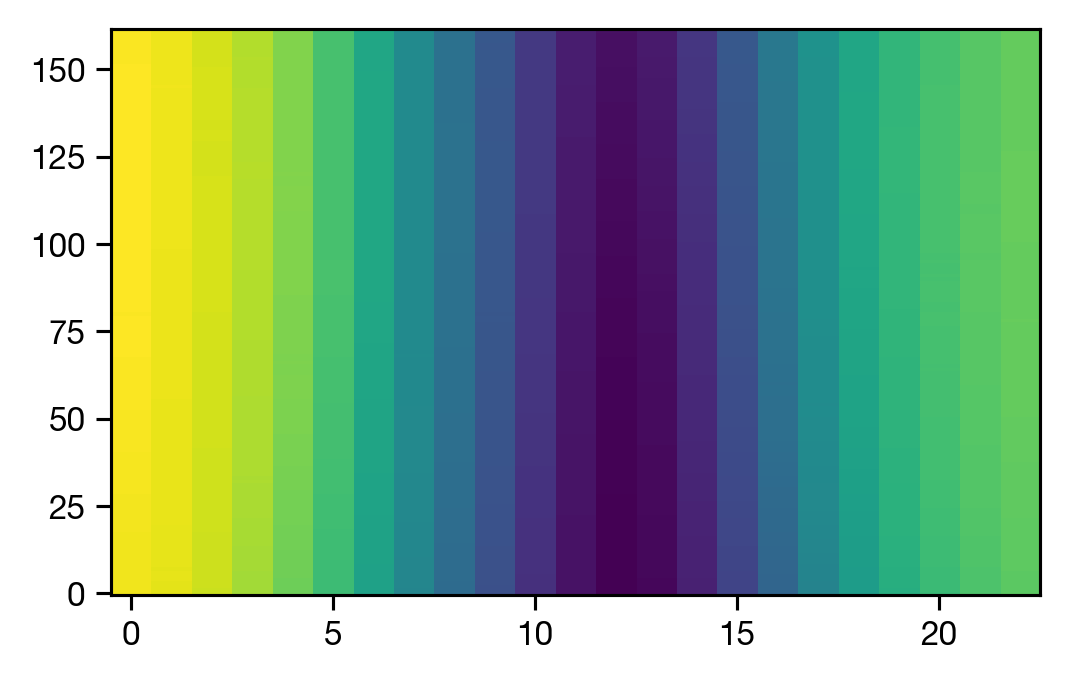

In [90]:
plt.imshow(grid_mz.T)
grid_mz.shape

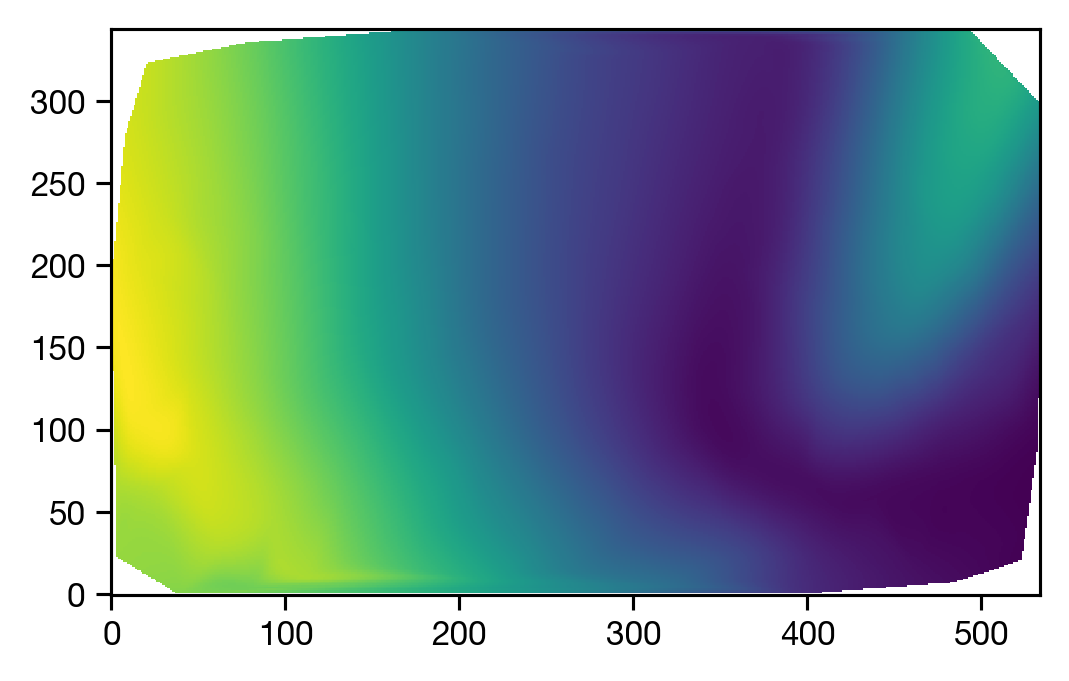

In [75]:
plt.imshow(grid_z)

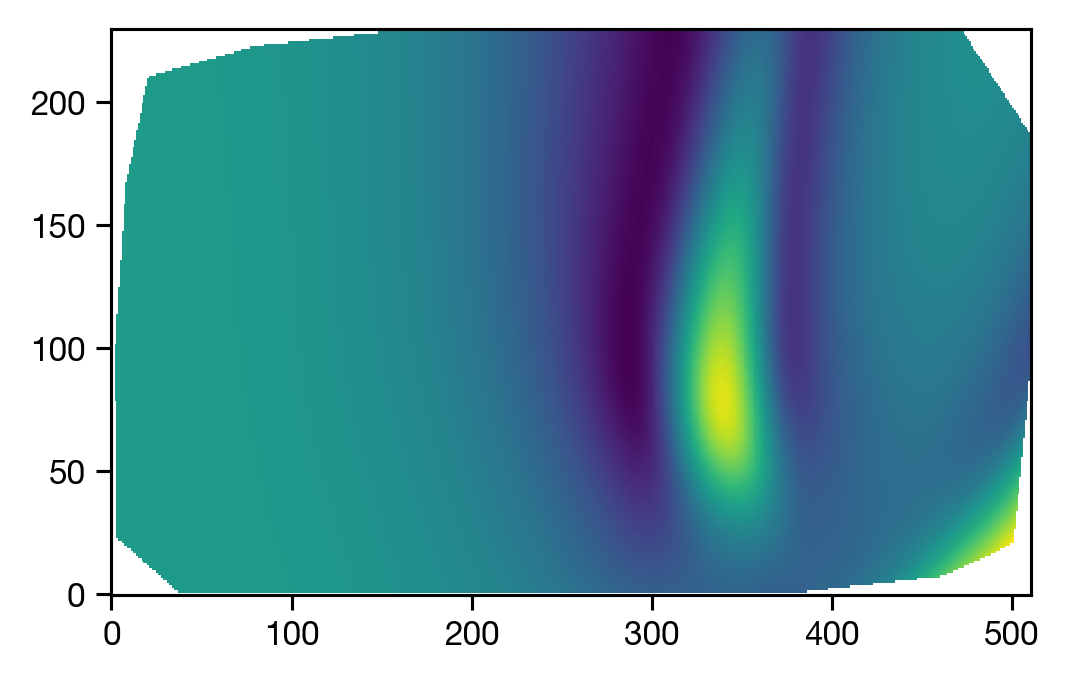

In [77]:
plt.imshow(np.log(np.abs(convmad)))

4.852599999999971 3.390340000000001


IndexError: index 0 is out of bounds for axis 0 with size 0

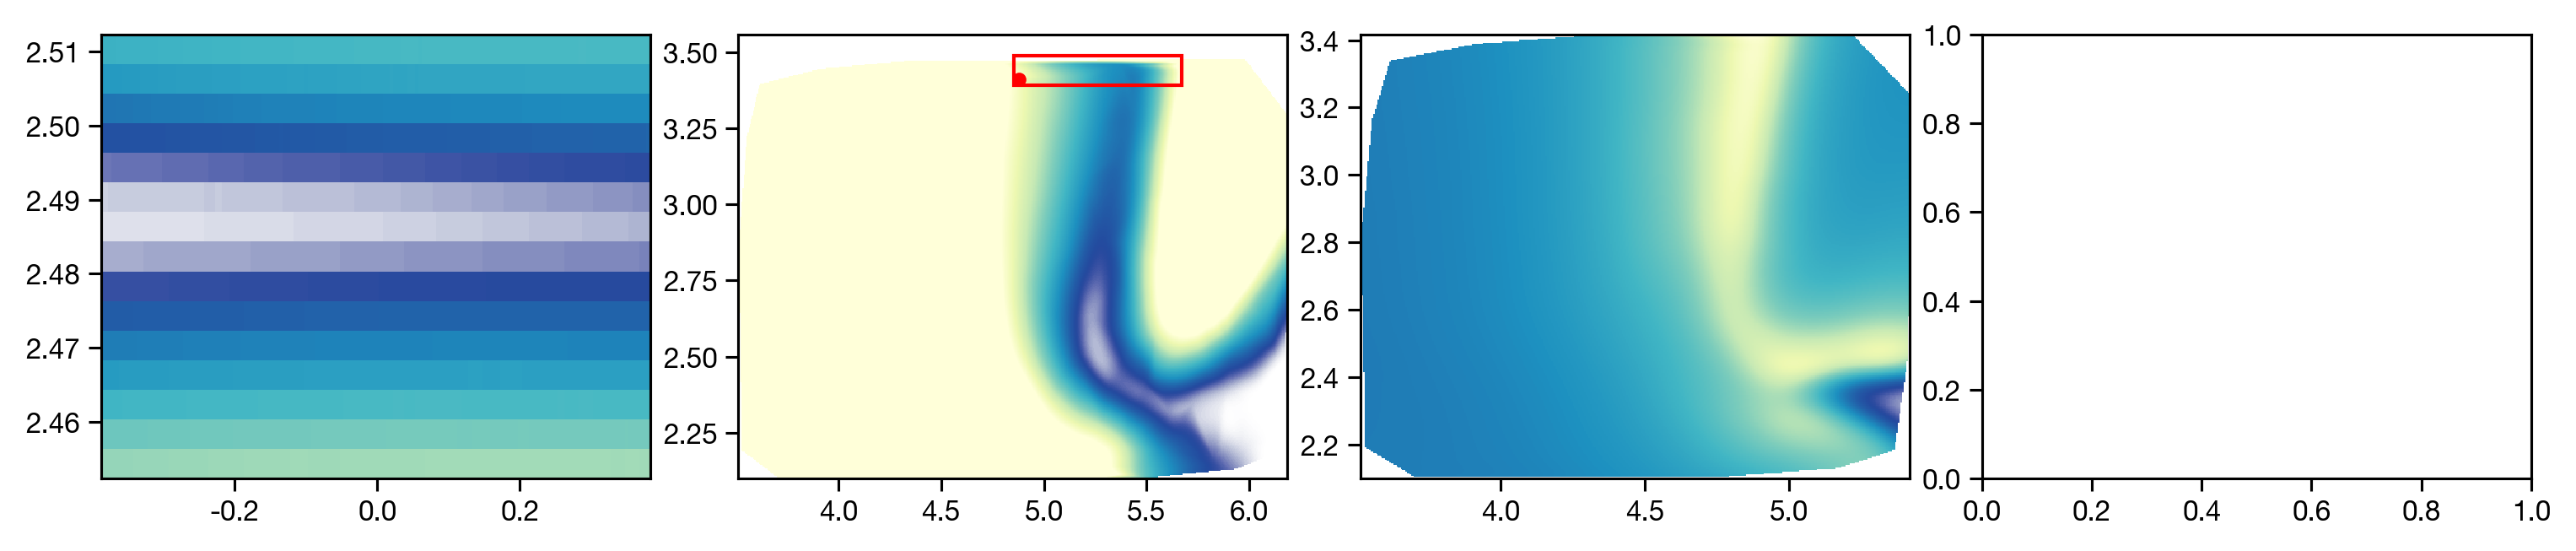

In [63]:

cq,cmed = 0.0005*0.006194404644103366/2.5884829867426733e-07,0.0005*0.006194404644103366/4.4384044126575746e-05
conv = -convmad #/(np.abs(np.nanmin(convmad))) - cq*convq/np.abs(np.nanmin(convq)) - cmed*convmed/np.abs(np.nanmin(convmed))


rows = conv.shape[0]
cols = conv.shape[1]
conv[np.isnan(conv)] = np.inf
cix,ciy = np.unravel_index(np.argmin(conv, axis=None), conv.shape),np.unravel_index(np.argmin(conv, axis=None), conv.shape)
mcx,mcy = grid_x[cix],grid_y[ciy]
cx,cy = grid_x[cix[0]-cuty,cix[1]-cutx],grid_y[ciy[0]-cuty,ciy[1]-cutx]

print(cx,cy)


fig,ax = plt.subplots(1,4,figsize=(10,2))
ax[0].pcolormesh(grid_mx[0,:],grid_my[:,0],grid_mz,cmap=mymap,vmin=elim[1][0],vmax=elim[1][1])
ax[1].pcolormesh(grid_x[0,:],grid_y[:,0],grid_z,cmap=mymap,vmin=elim[1][0],vmax=elim[1][1])
ax[1].plot(mcx,mcy,'r.')
rect = patches.Rectangle((cx, cy), lx, ly, linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)
ax[2].pcolormesh(grid_x[0,:cols],grid_y[:rows,0],1/conv,cmap=mymap)


lx = (model_data['x'].max() - model_data['x'].min())*1e-3
ly = (model_data['y'].max() - model_data['y'].min())
cutx_min = np.argwhere(grid_x[0,:]>cx)[0][0]
cuty_min = np.argwhere(grid_y[:,0]>cy)[0][0]
cutx_max = np.argwhere(grid_x[0,:]>(cx+lx))[0][0]
cuty_max = np.argwhere(grid_y[:,0]>cy+ly)[0][0]

ax[3].pcolormesh(grid_x[0,cutx_min:cutx_max],grid_y[cuty_min:cuty_max,0],grid_z[cuty_min:cuty_max,cutx_min:cutx_max],cmap=mymap,vmin=elim[1][0],vmax=elim[1][1])

ax[2].plot(mcx,mcy,'r.')

ax[0].set_ylabel('Laser energy (J)')
ax[0].set_xlabel('Focus position (mm)')
ax[1].set_xlabel('Focus position (mm)')
ax[2].set_xlabel('Focus position (mm)')

ax[0].set_title('Cut out of the modelled surface')
ax[1].set_title('Simulated surface')
ax[2].set_title('Difference between modelled \n and simulated surface')

plt.tight_layout()

In [60]:
cy

3.390340000000001